In [1]:
import os.path
import pickle

import numpy as np
import pandas as pd
from numba import jit
from scipy import stats
from sklearn.preprocessing import StandardScaler
from tqdm import notebook

In [2]:
## load data into np array
def convert_data_format_calms21_treba(data):
    # This is altered to fit with the calms21 data conversion script calms21_convert_to_npy.py
    ## Going through all sequences and creating giant dataframe
    keypoint_names = ['nose', 'ear_left', 'ear_right', 'neck', 'hip_left', 'hip_right', 'tail_base']
    keypoints_idx = pd.MultiIndex.from_product([['resident', 'intruder'], keypoint_names, list('xy')],
                                               names=['animal', 'keypoints', 'coords'])
    #task 1 has only 1 annotator (main key)
    data = data[list(data.keys())[0]]
    #sequence names are the keys of the dictionary
    sequence_names = list(data.keys())
    #sequence_names = list(data["sequences"].keys()) # old code
    collection = []
    targets = []
    for sequence_idx in range(len(sequence_names)):
        sequence_key = sequence_names[sequence_idx]
        single_sequence = data[sequence_key]
        #single_sequence = data["sequences"][sequence_key] # old code
        single_keypoints = single_sequence['features']

        collection.append(single_keypoints)
        # training we have annotations, but testing we do not.
        try:
            single_annotations = single_sequence['annotations']
            targets.append(np.array(single_annotations))
        except:
            pass
    if targets:
        return collection, targets
    else:
        return collection

### load dataset


The .npy files have the same dictionary layout, except the entries are
numpy arrays instead of lists.
If treba features are not appended, the final dictionary 'keypoint' entries will have shape:
sequence_length x 2 x 2 x 7.
If treba features are appended, the final dictionary 'features' entries will have shape:
sequence_length x 60 (2x2x7 + 32).

In [3]:
train = np.load('../raw_data/calms21_task1_train_features.npy', allow_pickle=True).item()

In [4]:
train_datalist, targets_raw = convert_data_format_calms21_treba(train)
len(train_datalist), train_datalist[0].shape, len(targets_raw)

(70, (21364, 60), 70)

## Let's embedd them with UMAP

In [5]:
import umap
import matplotlib.pyplot as plt
import numpy as np

output_path = '../processed_data/embeddings_treba.pkl'

feature_train = np.vstack(train_datalist)
print(feature_train.shape)

if os.path.exists(output_path):

    print("Embedding already exists")
    try:
        with open(output_path, 'rb') as f:
            embeddings_ = pickle.load(f)
    except:
        print("File exists but is corrupted")

        ## first generate embedding of all samples
        reducer = umap.UMAP(n_neighbors=60, n_components=2, min_dist=0.0, random_state=42)
        embeddings_ = reducer.fit_transform(feature_train)

else:
    ## first generate embedding of all samples
    reducer = umap.UMAP(n_neighbors=60, n_components=2, min_dist=0.0, random_state=42)
    embeddings_ = reducer.fit_transform(feature_train)
    with open(output_path, 'wb') as f:
        pickle.dump(embeddings_, f)


C:\Users\JSchw\anaconda3\envs\asoid_analysis\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\JSchw\anaconda3\envs\asoid_analysis\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\JSchw\anaconda3\envs\asoid_analysis\lib\site-packages\umap\dist

(507738, 60)
Embedding already exists


C:\Users\JSchw\anaconda3\envs\asoid_analysis\lib\site-packages\umap\umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


# plot embeddings

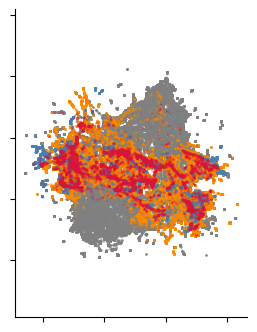

In [6]:
behavior_types = ["Attack", "Investigation", "Mount", "Other"]
cmap = ['crimson', 'darkorange', 'steelblue', 'k']
plt.style.use('default')
targets_train = np.hstack(targets_raw)

fig = plt.figure(figsize=(3, 4))
ax = fig.add_subplot()
for b in [3, 1, 2, 0]:
    if b == 3:
        idx_b_embed = np.where(targets_train==int(b))[0]
        ax.scatter(embeddings_[idx_b_embed, 0],
                   embeddings_[idx_b_embed, 1],
                   s=0.2, alpha=0.3, c='grey'
                   , label = behavior_types[b])

    else:
        idx_b_embed = np.where(targets_train==int(b))[0]
        ax.scatter(embeddings_[idx_b_embed, 0],
                   embeddings_[idx_b_embed, 1],
                   s=0.2,
                   alpha=0.3,
                   c=cmap[int(b)]
                   , label = behavior_types[b] )
ax.set_xticklabels('')
ax.set_yticklabels('')
color_name = "k"
ax.spines["bottom"].set_color(color_name)
ax.spines["left"].set_color(color_name)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
#plt.axis('on')
#plt.title('UMAP embedding of all samples (Feature bin = {} ms / {} frames)'.format(int(1/30*bin *1000), bin))
plt.axis('equal')

plt.savefig('../plots/Task1_UMAP_embedding_treba.png', dpi=300
            , bbox_inches='tight'
            , transparent=True)
plt.show()

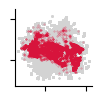

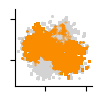

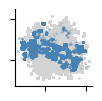

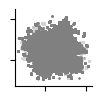

In [7]:

behavior_types = ['Attack', 'Investigation', 'Mount', 'Other']

for b in np.unique(targets_train):
    if b == 3:
        fig, ax = plt.subplots(1, 1, figsize=(1, 1))
        idx_b_embed = np.where(targets_train==int(b))[0]
        idx_not_b = np.where(targets_train!=int(b))[0]
        ax.scatter(embeddings_[idx_not_b, 0],
                   embeddings_[idx_not_b, 1],
                   s=0.1, alpha=0.5, c='lightgray')
        ax.scatter(embeddings_[idx_b_embed, 0],
                   embeddings_[idx_b_embed, 1],
                   s=0.1, alpha=0.5, c='gray')
    else:
        fig, ax = plt.subplots(1, 1, figsize=(1, 1))
        idx_b_embed = np.where(targets_train==int(b))[0]
        idx_not_b = np.where(targets_train!=int(b))[0]
        ax.scatter(embeddings_[idx_not_b, 0],
                   embeddings_[idx_not_b, 1],
                   s=0.1, alpha=0.5, c='lightgray')
        ax.scatter(embeddings_[idx_b_embed, 0],
                   embeddings_[idx_b_embed, 1],
                   s=0.1, alpha=0.5, c=cmap[int(b)])
    #ax.set_title(behavior_types[int(b)])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    color_name = "k"
    ax.spines["bottom"].set_color(color_name)
    ax.spines["left"].set_color(color_name)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    #plt.axis('on')
    #plt.title('UMAP embedding of all samples (Feature bin = {} ms / {} frames)'.format(int(1/30*bin *1000), bin))
    plt.axis('equal')
    plt.savefig('../plots/Task1_UMAP_embedding_treba_{}.png'.format(behavior_types[int(b)]), dpi=300, bbox_inches='tight'
                , transparent=True)
    plt.show()

